In [15]:
import numpy as np
np.version.version
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

In [16]:
# MNIST Fashion 데이터셋 로드
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_test.shape, y_test.shape)

(10000, 28, 28) (10000,)


In [17]:
# 데이터 전처리
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, -1)  # 채널 차원 추가
x_test = np.expand_dims(x_test, -1)  # 채널 차원 추가
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
print(x_test.shape, y_test.shape)

(10000, 28, 28, 1) (10000, 10)


In [7]:
# MNIST Fashion 클래스 이름
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

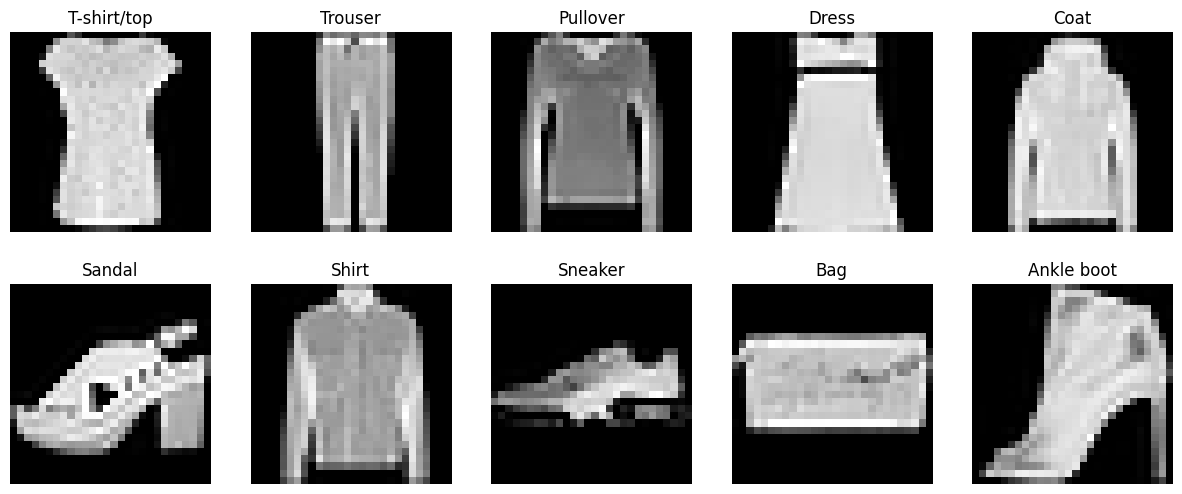

In [8]:
# 각 라벨별 데이터 예시 시각화
num_classes = len(class_names)
plt.figure(figsize=(15, 6))
for i in range(num_classes):
    idxs = np.where(y_train[:, i] == 1)[0]
    idx = np.random.choice(idxs)
    plt.subplot(2, num_classes // 2, i + 1)
    plt.imshow(x_train[idx].squeeze(), cmap='gray')
    plt.title(class_names[i])
    plt.axis('off')
plt.show()

In [9]:
# 연합학습을 위한 데이터 분할
num_clients = 5
client_data_size = len(x_train) // num_clients
client_data = [(x_train[i * client_data_size: (i + 1) * client_data_size],
                y_train[i * client_data_size: (i + 1) * client_data_size])
               for i in range(num_clients)]

In [10]:
# 모델 생성 함수
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
# 모델 생성
model = create_model()
model.summary()

/Users/jwheo/Projects/etc_project/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 클라이언트 모델 초기화
def initialize_client_models(num_clients, global_weights=None):
    client_models = []
    for _ in range(num_clients):
        model = create_model()
        if global_weights is not None:
            model.set_weights(global_weights)  # 모든 클라이언트 모델에 동일한 글로벌 가중치 설정
        client_models.append(model)
    return client_models

# FedAvg로 글로벌 모델 업데이트 함수
def federated_averaging(client_models, client_data):
    global_model = create_model()
    
    # 클라이언트 데이터 샘플 수를 기준으로 가중치 계산
    num_samples = [data[0].shape[0] for data in client_data]
    total_samples = sum(num_samples)
    client_weights = [samples / total_samples for samples in num_samples]
    
    # 각 클라이언트의 가중치를 평균화
    model_weights = [model.get_weights() for model in client_models]
    average_weights = []
    for weights_list in zip(*model_weights):
        average_weights.append(np.average(weights_list, axis=0, weights=client_weights))
    
    global_model.set_weights(average_weights)
    return global_model

# 각 클라이언트 모델 학습 함수
def train_client_model(client_data, model, epochs=5, batch_size=32):
    history = model.fit(client_data[0], client_data[1], epochs=epochs, batch_size=batch_size, verbose=1)
    return history

# 연합 학습 반복 함수
def federated_learning(num_rounds, num_clients, client_data):
    # 초기 글로벌 모델 설정
    global_model = create_model()
    global_model_accuracies = []
    
    for round in range(num_rounds):
        print(f"Round {round + 1}/{num_rounds}")
        
        # 클라이언트 모델 초기화
        client_models = initialize_client_models(num_clients, global_weights=global_model.get_weights())
        
        # 클라이언트 모델 학습
        for i in range(num_clients):
            print(f"Training client model {i + 1}...")
            train_client_model(client_data[i], client_models[i])
        
        # FedAvg로 글로벌 모델 생성
        global_model = federated_averaging(client_models, client_data)
        
        # 글로벌 모델 평가
        test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=0)
        global_model_accuracies.append(test_acc * 100)
        print(f'Global model test accuracy: {test_acc * 100:.2f}%')
        
        # 학습 상황 및 최종 결과 그래프
        client_accuracies = [model.evaluate(x_test, y_test, verbose=0)[1] for model in client_models]

        plt.figure(figsize=(10, 6))
        plt.plot(range(num_clients), client_accuracies, 'bo-', label='Client Models')
        plt.axhline(y=test_acc, color='r', linestyle='-', label='Global Model')
        plt.xlabel('Client')
        plt.ylabel('Accuracy')
        plt.title(f'Client Models vs Global Model Accuracy (Round {round + 1})')
        plt.legend()
        plt.show()
        # 특정 테스트 인덱스를 선택하여 예측 결과 시각화
        num_samples = x_test.shape[0]
        test_index = np.random.randint(num_samples)

        plt.figure(figsize=(12, 6))

        for i in range(num_clients):
            plt.subplot(2, num_clients, i + 1)
            plt.imshow(x_test[test_index].squeeze(), cmap='gray')
            client_prediction = np.argmax(client_models[i].predict(x_test[test_index:test_index+1]))
            true_label = np.argmax(y_test[test_index])
            plt.title(f"Client {i+1}\nPred: {client_prediction}\nTrue: {true_label}")
            plt.axis('off')

        plt.subplot(2, num_clients, num_clients + 1)
        plt.imshow(x_test[test_index].squeeze(), cmap='gray')
        global_prediction = np.argmax(global_model.predict(x_test[test_index:test_index+1]))
        true_label = np.argmax(y_test[test_index])
        plt.title(f"Global Model\nPred: {global_prediction}\nTrue: {true_label}")
        plt.axis('off')

        plt.show()

    return global_model, global_model_accuracies

In [14]:
# 연합 학습 수행
print(x_test.shape, y_test.shape)
num_rounds = 7
global_model, global_model_accuracies = federated_learning(num_rounds, num_clients, client_data)


# 최종 글로벌 모델 평가
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=0)
print(f'Final global model test accuracy: {test_acc * 100:.2f}%')

# 라운드에 따른 글로벌 모델 정확도 변화 그래프
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_rounds + 1), global_model_accuracies, 'r-o', label='Global Model Accuracy')
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.title('Global Model Accuracy Over Rounds')
plt.legend()
plt.show()

(10000, 28, 28, 1) (10000, 10)
Round 1/7
Training client model 1...
Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.2964 - loss: 1.9809
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6829 - loss: 0.8701
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.7318 - loss: 0.7213
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.7490 - loss: 0.6564
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.7715 - loss: 0.6039
Training client model 2...
Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.2960 - loss: 1.9798
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.6687 - loss: 0.9030
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.7206 - loss: 0.7560
Epoch 4/5
210/375 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7425 - loss: 0.6771

KeyboardInterrupt: 